In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%matplotlib inline
import sys
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from multiprocessing import Pool
from functools import partial

from CrossValidation import *
from FeatureSimilarity import GetTopGenes, GetTopGenesMulti
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

from utils import *

In [6]:
plt.rcParams['figure.figsize'] = [8, 6]
sns.set(font_scale=1.5)

In [7]:
totalDataDF = pd.read_csv('/projects/leelab3/psturm/concatData/totalDataDF.csv', header=0, index_col=0)

In [8]:
totalDataDF.tail()

,488395315,496100277,496100278,496100279,496100281,496100283,496100284,496100285,496100287,496100288,...,1021204186,3451205016,4971205156,5371205166,1731204246,1321204196,4291205076,1081204186,651204176,2581204266
PCG,,,,,,,,,,,,,,,,,,,,,
BRAAK,0.500000,0.500000,1.000000,1.000000,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,...,0.333333,0.166667,0.833333,0.833333,0.833333,0.666667,0.500000,0.666667,0.500000,0.833333
CERAD,1.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.666667,...,0.666667,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.666667,0.000000,0.666667
PLAQUES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.193955,0.000000,0.424560,0.549603,0.569194,0.000000,0.207878,0.306999,0.000000,0.192465
ABETA_IHC,0.466675,0.038185,0.004278,0.010662,0.033745,0.040946,0.010449,0.355101,0.132327,0.035876,...,0.200114,0.022805,0.244584,0.479285,0.022235,0.000000,0.214177,0.502471,0.000000,0.309768
TAU_IHC,0.096909,0.002176,0.000532,0.000806,0.510205,0.001087,0.001712,0.001887,0.012920,0.120113,...,0.000000,0.000000,0.047492,0.029338,0.038281,0.000000,0.001878,0.000102,0.000162,0.000638


In [9]:
X = totalDataDF.values
X.shape

(16869, 1799)

In [10]:
binaryPathwayDF = pd.read_csv('/projects/leelab3/psturm/concatData/pathways.tsv', sep='\t', header=0)
binaryPathwayDF.set_index('Genes', inplace=True)

In [11]:
learnedV = np.load('/projects/leelab3/psturm/realModels/V.npy')

In [12]:
learnedV.shape

(16869, 356)

In [13]:
braakIndex = totalDataDF.index.get_loc('BRAAK')
ceradIndex = totalDataDF.index.get_loc('CERAD')
plaqIndex  = totalDataDF.index.get_loc('PLAQUES')
abetaIndex = totalDataDF.index.get_loc('ABETA_IHC')
tauIndex   = totalDataDF.index.get_loc('TAU_IHC')
allIndex   = np.array([braakIndex, ceradIndex, plaqIndex, abetaIndex, tauIndex])
geneIndices = np.arange(braakIndex)

In [14]:
learnedBraak = learnedV[braakIndex, :]
learnedCerad = learnedV[ceradIndex, :]
learnedPlaq  = learnedV[plaqIndex, :]
learnedAbeta = learnedV[abetaIndex, :]
learnedTau   = learnedV[tauIndex, :]
learnedPheno = learnedV[allIndex, :].T

In [15]:
def project(V, p):
    return -1.0 * np.linalg.norm(V - p, axis=1)
def projectMulti(V, p):
    return -1.0 * np.mean(np.linalg.norm(V[:, :, None] - p[None, :, :], axis=1), axis=1)
braakProjections = project(learnedV[geneIndices, :], learnedBraak)
ceradProjections = project(learnedV[geneIndices, :], learnedBraak)
plaqProjections  = project(learnedV[geneIndices, :], learnedBraak)
abetaProjections = project(learnedV[geneIndices, :], learnedBraak)
tauProjections   = project(learnedV[geneIndices, :], learnedBraak)
allProjections   = projectMulti(learnedV[geneIndices, :], learnedPheno)

In [16]:
identifiedIndices = GetTopGenesMulti(learnedV, allIndex, geneIndices)
identifiedGenes = totalDataDF.index.values[identifiedIndices]
importanceGroup = np.array(['candidate genes' if i in identifiedIndices[0:100] else 'genes' for i in range(len(identifiedIndices))])

In [17]:
projectionDF = pd.DataFrame({
    'Braak Score': braakProjections,
    'Cerad Score': ceradProjections,
    'Plaque Score': plaqProjections,
    'ABeta Score': abetaProjections,
    'Tau Score': tauProjections,
    'Mean Score': allProjections,
    'Names': totalDataDF.index[geneIndices],
    'is_candidate': importanceGroup
})

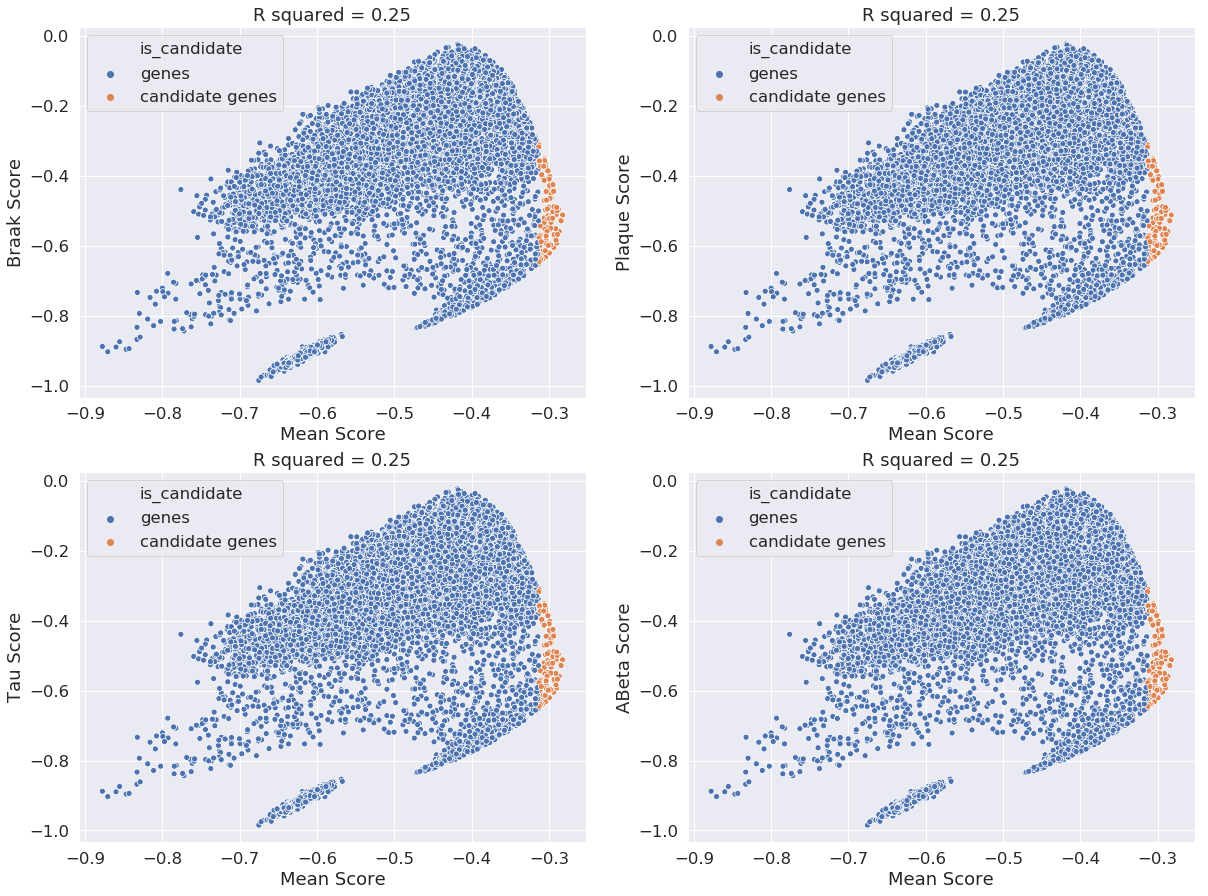

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
i = 0
y_names = ['Braak Score', 'Tau Score', 'Plaque Score', 'ABeta Score']
for name in y_names:
    R, p = scipy.stats.pearsonr(projectionDF['Mean Score'].values, projectionDF[name].values)
    sns.scatterplot(x='Mean Score', y=name, data=projectionDF, hue='is_candidate', 
                    ax=axs[i % 2, int(i / 2)])
    axs[i % 2, int(i / 2)].set_title('R squared = {:.2f}'.format(R*R))
    i = i + 1

In [19]:
identifiedGenes[1:20]

array(['SPTA1', 'FASLG', 'ICOS', 'CNR2', 'CD5L', 'VRTN', 'PAX1', 'ENPP7',
       'PDCD1', 'CLEC1B', 'CALCA', 'NEIL3', 'DLGAP5', 'BLK', 'SIT1',
       'NTS', 'CCR4', 'CXCL9', 'CEACAM3'], dtype=object)

In [20]:
braakProjections[identifiedIndices[1:20]]

array([-0.52847123, -0.5268716 , -0.52595395, -0.5594087 , -0.49712643,
       -0.5671722 , -0.4994305 , -0.5922041 , -0.48988035, -0.5103968 ,
       -0.5771766 , -0.58365387, -0.55091184, -0.57299113, -0.56784725,
       -0.48778564, -0.60453737, -0.44415087, -0.43936187], dtype=float32)

In [21]:
binaryPathwayDF.head()

,REACTOME_GLYCOGEN_BREAKDOWN_GLYCOGENOLYSIS,REACTOME_TRANSLATION,REACTOME_PYRIMIDINE_CATABOLISM,REACTOME_RNA_POL_III_TRANSCRIPTION_INITIATION_FROM_TYPE_2_PROMOTER,REACTOME_INHIBITION_OF_THE_PROTEOLYTIC_ACTIVITY_OF_APC_C_REQUIRED_FOR_THE_ONSET_OF_ANAPHASE_BY_MITOTIC_SPINDLE_CHECKPOINT_COMPONENTS,REACTOME_PYRUVATE_METABOLISM_AND_CITRIC_ACID_TCA_CYCLE,REACTOME_EXTRINSIC_PATHWAY_FOR_APOPTOSIS,REACTOME_PTM_GAMMA_CARBOXYLATION_HYPUSINE_FORMATION_AND_ARYLSULFATASE_ACTIVATION,REACTOME_APOPTOTIC_CLEAVAGE_OF_CELLULAR_PROTEINS,REACTOME_RNA_POL_I_TRANSCRIPTION_TERMINATION,...,REACTOME_DIGESTION_OF_DIETARY_CARBOHYDRATE,REACTOME_FGFR1_LIGAND_BINDING_AND_ACTIVATION,REACTOME_GAP_JUNCTION_ASSEMBLY,REACTOME_SYNTHESIS_OF_GLYCOSYLPHOSPHATIDYLINOSITOL_GPI,REACTOME_RNA_POL_I_TRANSCRIPTION_INITIATION,REACTOME_PYRIMIDINE_METABOLISM,REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS,REACTOME_PI3K_CASCADE,REACTOME_APOPTOTIC_EXECUTION_PHASE,REACTOME_SHC_RELATED_EVENTS
Genes,,,,,,,,,,,,,,,,,,,,,
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2LD1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
raw_scores = []
for pathway in binaryPathwayDF.columns.values:
    pathwayGenes = np.where(binaryPathwayDF[pathway] == 1)[0]
    meanProjectionScore = np.nanmean(X[pathwayGenes])
    raw_scores.append(meanProjectionScore)

In [26]:
rawInds = np.argsort(raw_scores)

In [22]:
scores = []
for pathway in binaryPathwayDF.columns.values:
    pathwayGenes = np.where(binaryPathwayDF[pathway] == 1)[0]
    meanProjectionScore = np.mean(allProjections[pathwayGenes])
    scores.append(meanProjectionScore)

In [23]:
pathwayIndices = np.argsort(scores)[::-1]

In [37]:
names = ['EXTRINSIC_PATHWAY_FOR_APOPTOSIS', 'CREATION_OF_C4_AND_C2_ACTIVATORS', 'GABA_A_RECEPTOR_ACTIVATION', 'LIGAND_GATED_ION']

anyPaths = np.unique(np.where(binaryPathwayDF.values > 0)[0])

pathwayProjDF = projectionDF.copy()

pathwayProjDF['pathway_type'] = ['default'] * pathwayProjDF.shape[0]
for name in names:  
    namePaths = np.array([i for i in range(len(binaryPathwayDF.columns.values)) if name in binaryPathwayDF.columns.values[i]])
    nameGenes = np.unique(np.where(binaryPathwayDF.values[:, namePaths] > 0)[0])
    pathwayProjDF.loc[nameGenes, 'pathway_type'] = name

pathwayProjDF = pathwayProjDF.iloc[anyPaths]

pathwayProjDF.sort_values('pathway_type', inplace=True, ascending=False)

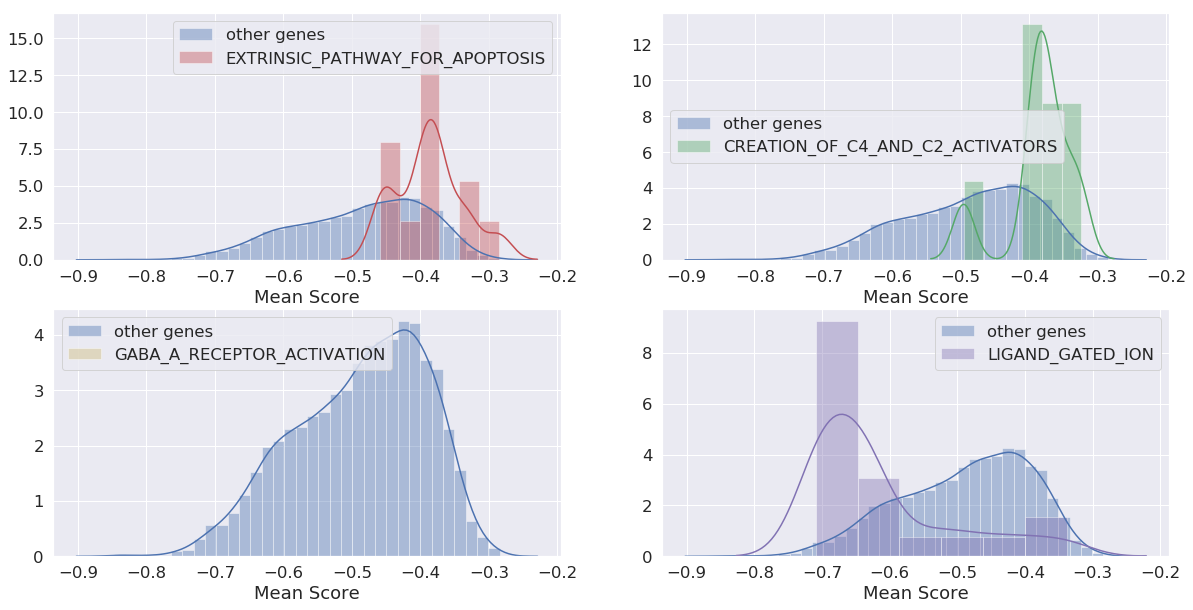

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
# fig.tight_layout()

i = 0
colors = ['r', 'g', 'y', 'm']
for name in names: 
    sns.distplot(pathwayProjDF[pathwayProjDF['pathway_type'] == 'default']['Mean Score'],  kde=True, 
                 ax=axs[int(i / 2), i % 2], color='b', label='other genes')
    sns.distplot(pathwayProjDF[pathwayProjDF['pathway_type'] == name]['Mean Score'], kde=True, color=colors[i], 
                 norm_hist=True, ax=axs[int(i / 2), i % 2], label=name)
    axs[int(i / 2), i % 2].legend()
    i = i + 1

In [181]:
np.where('GABA' in binaryPathwayDF.columns.values)

(array([], dtype=int64),)

In [28]:
# for i in range(len(pathwayIndices)):
#     pathwayName = binaryPathwayDF.columns.values[rawInds[i]]
#     print('Score:{:.5f}\tPathway:{}'.format(raw_scores[rawInds[i]], pathwayName[:75] + (pathwayName[75:] and '...')))

In [24]:
for i in range(len(pathwayIndices)):
    pathwayName = binaryPathwayDF.columns.values[pathwayIndices[i]]
    print('Score:{:.5f}\tPathway:{}'.format(scores[pathwayIndices[i]], pathwayName[:75] + (pathwayName[75:] and '...')))

Score:-0.38127	Pathway:REACTOME_INITIAL_TRIGGERING_OF_COMPLEMENT
Score:-0.38468	Pathway:REACTOME_CREATION_OF_C4_AND_C2_ACTIVATORS
Score:-0.38655	Pathway:REACTOME_EXTRINSIC_PATHWAY_FOR_APOPTOSIS
Score:-0.40090	Pathway:REACTOME_NFKB_ACTIVATION_THROUGH_FADD_RIP1_PATHWAY_MEDIATED_BY_CASPASE_8_AN...
Score:-0.40804	Pathway:REACTOME_TRANSLOCATION_OF_ZAP_70_TO_IMMUNOLOGICAL_SYNAPSE
Score:-0.40834	Pathway:REACTOME_PD1_SIGNALING
Score:-0.40904	Pathway:REACTOME_TRAF6_MEDIATED_NFKB_ACTIVATION
Score:-0.40905	Pathway:REACTOME_NFKB_IS_ACTIVATED_AND_SIGNALS_SURVIVAL
Score:-0.40964	Pathway:REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_ACTIVITY_BY_INSULIN_L...
Score:-0.41518	Pathway:REACTOME_PHOSPHORYLATION_OF_CD3_AND_TCR_ZETA_CHAINS
Score:-0.41575	Pathway:REACTOME_COMPLEMENT_CASCADE
Score:-0.41680	Pathway:REACTOME_PECAM1_INTERACTIONS
Score:-0.41860	Pathway:REACTOME_VEGF_LIGAND_RECEPTOR_INTERACTIONS
Score:-0.41888	Pathway:REACTOME_P75NTR_SIGNALS_VIA_NFKB
Score:-0.42197	Pathway:REACTOME_CHYLOMICR